# Artist identification of a Painting

## Problem Statement : 
Identify Van Gogh's painting from a given dataset

## Dataset Link :
https://figshare.com/articles/From_Impressionism_to_Expressionism_Automatically_Identifying_Van_Gogh_s_Paintings/3370627

# Importing required libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.applications import *


from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from scipy.sparse import csr_matrix

np.random.seed(42)

Using TensorFlow backend.


# Some anaylsis on data

## Number of train and test samples

In [2]:
pos_train_dir = './vgdb_2016/train/vg'
neg_train_dir = './vgdb_2016/train/nvg'
pos_test_dir = './vgdb_2016/test/vg'
neg_test_dir = './vgdb_2016/test/nvg'

pos_train_samples = os.listdir(pos_train_dir)
neg_train_samples = os.listdir(neg_train_dir)
pos_test_samples = os.listdir(pos_test_dir)
neg_test_samples = os.listdir(neg_test_dir)

train_samples = pos_train_samples + neg_train_samples
test_samples = pos_test_samples + neg_test_samples
print('Total number of train images of Van Gogh\'s paintings', len(pos_train_samples))
print('Total number of train images of other artist\'s paintings', len(neg_train_samples))
print('Total number of test images of Van Gogh\'s paintings', len(pos_test_samples))
print('Total number of test images of other artist\'s paintings', len(neg_test_samples))
print('Total training images', len(train_samples))
print('Total test images', len(test_samples))

Total number of train images of Van Gogh's paintings 99
Total number of train images of other artist's paintings 165
Total number of test images of Van Gogh's paintings 25
Total number of test images of other artist's paintings 42
Total training images 264
Total test images 67


## Displaying an image of Van Gogh painting and other artists painting

Image of Van Gogh's painting


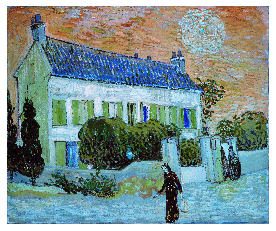

Size of image (5900, 7107, 3)
Image of other artist's painting


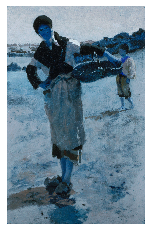

Size of image (3637, 2297, 3)


In [3]:
#reading an image of Van Gogh's painting
fname = './vgdb_2016/train/vg/vg_809945.png'

print('Image of Van Gogh\'s painting')
img = cv2.imread(fname, 1)
plt.imshow(img)
plt.xticks([]), plt.yticks([])             #to hide tick values on X and Y axis
plt.show()

print('Size of image', img.shape)

#reaing an image of other artist painting
fname = 'vgdb_2016/train/nvg/nvg_31699808.png'

print('Image of other artist\'s painting')
img = cv2.imread(fname, 1)
plt.imshow(img)
plt.xticks([]), plt.yticks([])             #to hide tick values on X and Y axis
plt.show()

print('Size of image', img.shape)

As each image is of very large size and classifying each painting can be tough task for the model, we need to identify some specific features in the image that will help in classification. The features can be extracted using pretrained models like VGG16, VGG19, ResNet and InceptionNet

These are the steps that we will follow

For train data, we will 
1. Create 10 patches of from each image 
2. Extract features of these patches using above models.
3. Train a logistic regression or svm on these extracted features.

Hence we will have 10 patches per training image. Total taining images are 264 hence we will have 2640 patch features for our taining set.


For test set, we will 
1. Take each image create its 10 patches
2. Extract features of these 10 patches using above models
3. Classify the patches into 1/0 using the logistic regression or svm model, we train above.

Hence for each image we will have 10 predictions, we will take mean of these 10 predictions to predict that the complete image  belongs to Class 1 or 0.

## Displaying an image and its patches

In [0]:
#function to get patches from an image
def get_patches(img_path, patch_size, no_of_patches):
    patches = []
    img = cv2.imread(img_path, 1)
    
    image_height = img.shape[0]
    image_width = img.shape[1]

    #substracting patch_size from image height and width so as to avoid getting out of dimension error when creating patches
    range_x = image_height - patch_size
    range_y = image_width - patch_size

    for i in range(no_of_patches):
        x = np.random.randint(low = 0, high = range_x)
        y = np.random.randint(low = 0, high = range_y)

        patch = img[x : x+patch_size, y : y+patch_size, :]
        patches.append(patch)
    return patches

Image of Van Gogh's painting


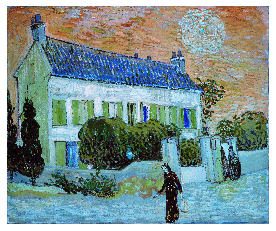

Patches of above image


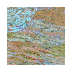

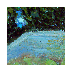

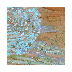

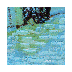

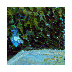

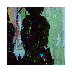

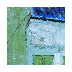

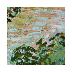

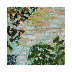

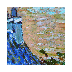

In [5]:
#displaying image and its patches
patch_size = 1024
no_of_patches = 10
img_path = './vgdb_2016/train/vg/vg_809945.png'

#creating some patches from above image
patches = get_patches(img_path, patch_size, no_of_patches)

#display image
print('Image of Van Gogh\'s painting')
img = cv2.imread(img_path, 1)
plt.imshow(img)
plt.xticks([]), plt.yticks([])          #to hide tick values on X and Y axis
plt.show()

    
#displaying patches of above image
print('Patches of above image')
for i in range(no_of_patches):
    plt.subplot(2,5,i+1)
    plt.imshow(patches[i])
    plt.xticks([]), plt.yticks([])          #to hide tick values on X and Y axis
    plt.show()

In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A = (((C.T)/(C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]

    # representing A in heatmap format
    cmap = sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

# Modelling

# VGG16

In [7]:
vgg16model = vgg16.VGG16(include_top = False, weights = 'imagenet')

Instructions for updating:
Colocations handled automatically by placer.


## Creating train dataset

Here we, 
1. Create 10 patches of from each image 
2. Extract features of these patches using VGG16 model. 
3. Train a logistic regression on these extracted features.

In [0]:
#function to extract features using vgg16 model
def get_patch_feature_vgg16(patch):
    patch_data = np.expand_dims(patch, axis = 0)             #changing the shape of image to 4d, the extra dimension is for batch
    patch_data = vgg16.preprocess_input(patch_data)                #shape = (1, 224, 224, 3)

    patch_feature = vgg16model.predict(patch_data)           #output shape for resnet50 = (1, 7 , 7, 2048)
    patch_feature = patch_feature.reshape(25088)
    return patch_feature

In [9]:
patch_size = 224                            #patch_size for vgg16 model
no_of_patches = 10                          #hyperparameter that can be tuned
X_train = []
Y_train = []

#for positive training samples
print('Creating patch_features for postive training samples...')
for file_name in pos_train_samples:                                  #for each image
    img_path = pos_train_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_vgg16(patch)
        X_train.append(patch_feature)                                #append patch feature
        Y_train.append(1)                                            #append 1 for positive samples


#for negative training samples
print('Creating patches for negative training samples...')
for file_name in neg_train_samples:                                  #for each image
    img_path = neg_train_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_vgg16(patch)
        X_train.append(patch_feature)                                #append patch feature
        Y_train.append(0)                                            #append 0 for positive samples
        
print('Total number of train data points', len(X_train))

Creating patch_features for postive training samples...
Creating patches for negative training samples...
Total number of train data points 2640


## Splitting the dataset

In [10]:
#our train data is arranged as all positive samples, then all negative samples.
#Shuffling train data

X_train, Y_train = shuffle(X_train, Y_train)
X_train = csr_matrix(X_train)

X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)
print("Shape of tr data, cv data and test data is :", X_tr.shape, X_cv.shape)

Shape of tr data, cv data and test data is : (2112, 25088) (528, 25088)


## Logistic Regression Model

### Parameter Tuning

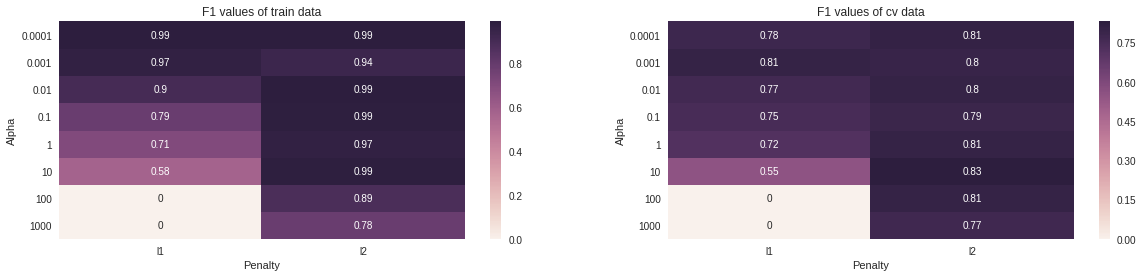

In [11]:
alpha = [10**i for i in range(-4, 4)]
penalty = ['l1', 'l2']
f1_tr_array = []
f1_cv_array = []
for i in alpha:
    for j in penalty:
        clf = SGDClassifier(alpha = i, penalty = j, loss = 'log')
        clf.fit(X_tr, Y_tr)
        pred_tr = clf.predict(X_tr)
        pred_cv = clf.predict(X_cv)

        f1_tr_array.append(f1_score(Y_tr, pred_tr))
        f1_cv_array.append(f1_score(Y_cv, pred_cv))

        
#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
f1_tr_array = np.array(f1_tr_array)
f1_tr_array = f1_tr_array.reshape(len(alpha),len(penalty))
sns.heatmap(f1_tr_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('F1 values of train data')

plt.subplot(1, 2, 2)
f1_cv_array = np.array(f1_cv_array)
f1_cv_array = f1_cv_array.reshape(len(alpha),len(penalty))
sns.heatmap(f1_cv_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('F1 values of cv data')
plt.show()

### Model with best parameter

Values of best parameters are alpha : 10 and penalty : l2
Training on best parameters...
For best parameters train f1 score is 0.9783715012722647 and cv f1 score is 0.8179271708683473


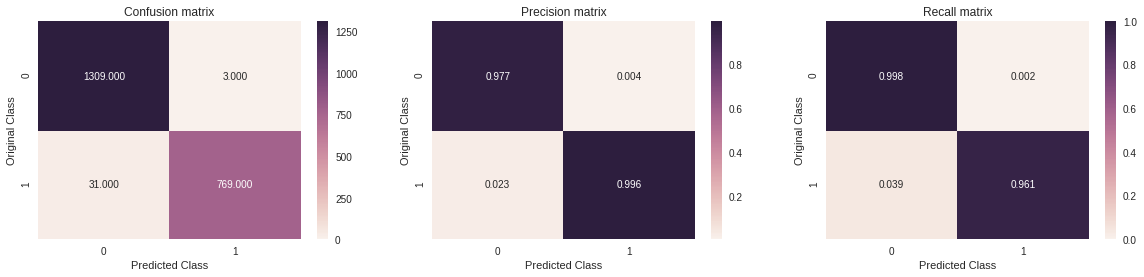

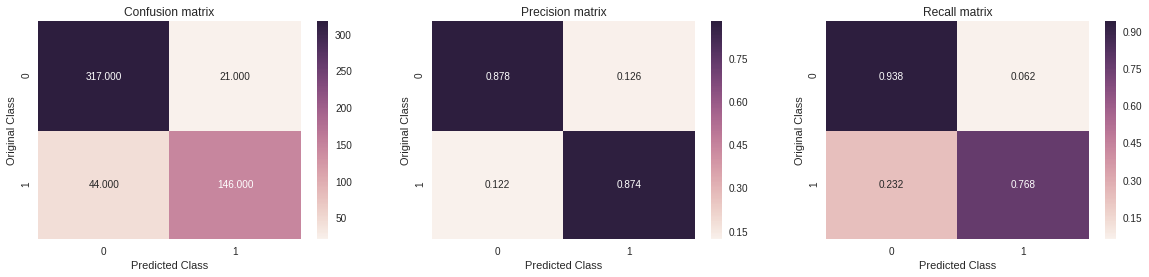

In [12]:
print("Values of best parameters are alpha : 10 and penalty : l2")
print("Training on best parameters...")

clf = SGDClassifier(alpha = 10, penalty = 'l2', loss = 'log')
clf.fit(X_tr, Y_tr)

pred_tr = clf.predict(X_tr)
pred_cv = clf.predict(X_cv)

f1_tr_lr = f1_score(Y_tr, pred_tr)
f1_cv_lr = f1_score(Y_cv, pred_cv)

print("For best parameters train f1 score is", f1_tr_lr, "and cv f1 score is", f1_cv_lr)
plot_confusion_matrix(Y_tr, pred_tr)
plot_confusion_matrix(Y_cv, pred_cv)

## Predictions on test data

Here we, 
1. Take each test image create its 10 patches
2. Extract features of these 10 patches using VGG16 model
3. Classify the patches into 1/0 using the logistic regression we trained above.

In [13]:
clf = SGDClassifier(alpha = 10, penalty = 'l2', loss = 'log')
clf.fit(X_tr, Y_tr)

patch_size = 224                            #patch_size for vgg16 model
no_of_patches = 10                          #hyperparameter that can be tuned
Y_test = []                                 #stores ture labels
pred_test = []                              #stores probabiltes of predicted lables

#for positive training samples
print('Testing on positives images...')
for file_name in pos_test_samples:                                   #for each image
    pred_patch = []                                                  #list to store probabilites value for each patch
    img_path = pos_test_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)       
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_vgg16(patch)
        pred = clf.predict_proba([patch_feature])                    #predict probabilites for each patch
        pred_patch.append(pred[0])                                   #append probabilites, here pred is a list containing a list of probabilites of 2 class 
        
    pred_test.append(np.mean(pred_patch, axis = 0))                  #append mean of patch probabilites
    Y_test.append(1)                                                 #appending 1 for positive samples

    
#for negative training samples
print('Testing on negative images...')
for file_name in neg_test_samples:                                   #for each image
    pred_patch = []                                                  #list to store probabilites value for each patch
    img_path = neg_test_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_vgg16(patch)
        pred = clf.predict_proba([patch_feature])                    #predict probabilites for each patch
        pred_patch.append(pred[0])                                   #append probabilites, here pred is a list containing a list of probabilites of 2 class 
        
    pred_test.append(np.mean(pred_patch, axis = 0))                  #append mean of patch probabilites
    Y_test.append(0)                                                 #appending 0 for negative samples

Testing on positives images...
Testing on negative images...


In [14]:
#Convert probabilites into classes
pred_test = np.argmax(pred_test, axis = 1)
print('Predicted Classes for each test image are :', pred_test)
print('Ture Classes for each test image are :', Y_test)

Predicted Classes for each test image are : [1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ture Classes for each test image are : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


F1 score for test data is 0.8846153846153846


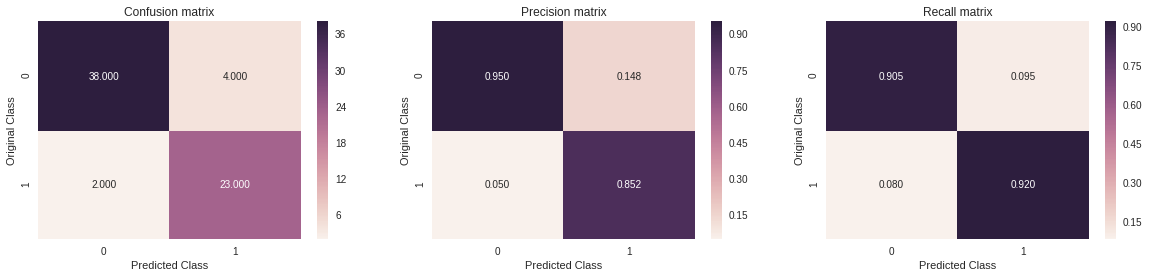

In [15]:
f1_test_vgg16 = f1_score(Y_test, pred_test)

print("F1 score for test data is", f1_test_vgg16)
plot_confusion_matrix(Y_test, pred_test)

# VGG19

In [0]:
vgg19model = vgg19.VGG19(include_top = False, weights = 'imagenet')                #not importing the top layer

## Creating train dataset

Here we, 
1. Create 10 patches of from each image 
2. Extract features of these patches using VGG19 model. 
3. Train a logistic regression on these extracted features.

In [0]:
#function to extract features using vgg19 model
def get_patch_feature_vgg19(patch):
    patch_data = np.expand_dims(patch, axis = 0)             #changing the shape of image to 4d, the extra dimension is for batch
    patch_data = vgg19.preprocess_input(patch_data)                #shape = (1, 224, 224, 3)

    patch_feature = vgg19model.predict(patch_data)           #output shape for resnet50 = (1, 7 , 7, 2048)
    patch_feature = patch_feature.reshape(25088)
    return patch_feature

In [18]:
patch_size = 224                            #patch_size for vgg19 model
no_of_patches = 10                          #hyperparameter that can be tuned
X_train = []
Y_train = []

#for positive training samples
print('Creating patch_features for postive training samples...')
for file_name in pos_train_samples:                                  #for each image
    img_path = pos_train_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_vgg19(patch)
        X_train.append(patch_feature)                                #append patch feature
        Y_train.append(1)                                            #append 1 for positive samples


#for negative training samples
print('Creating patches for negative training samples...')
for file_name in neg_train_samples:                                  #for each image
    img_path = neg_train_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_vgg19(patch)
        X_train.append(patch_feature)                                #append patch feature
        Y_train.append(0)                                            #append 0 for positive samples
        
print('Total number of train data points', len(X_train))

Creating patch_features for postive training samples...
Creating patches for negative training samples...
Total number of train data points 2640


## Splitting the dataset

In [19]:
#our train data is arranged as all positive samples, then all negative samples.
#Shuffling train data

X_train, Y_train = shuffle(X_train, Y_train)
X_train = csr_matrix(X_train)

X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)
print("Shape of tr data, cv data and test data is :", X_tr.shape, X_cv.shape)

Shape of tr data, cv data and test data is : (2112, 25088) (528, 25088)


## Logistic Regression Model

### Parameter Tuning

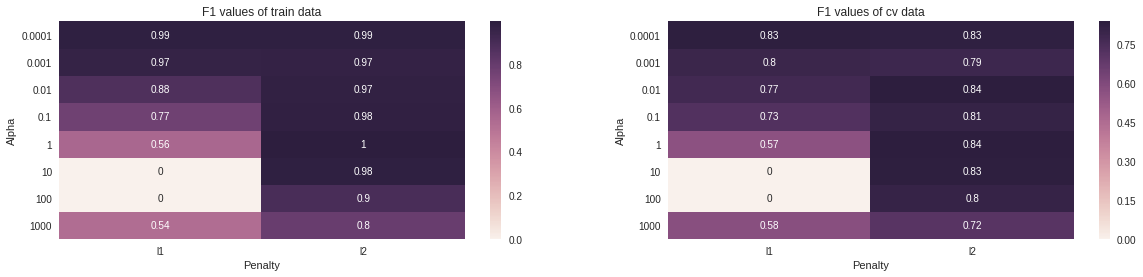

In [20]:
alpha = [10**i for i in range(-4, 4)]
penalty = ['l1', 'l2']
f1_tr_array = []
f1_cv_array = []
for i in alpha:
    for j in penalty:
        clf = SGDClassifier(alpha = i, penalty = j, loss = 'log')
        clf.fit(X_tr, Y_tr)
        pred_tr = clf.predict(X_tr)
        pred_cv = clf.predict(X_cv)

        f1_tr_array.append(f1_score(Y_tr, pred_tr))
        f1_cv_array.append(f1_score(Y_cv, pred_cv))

        
#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
f1_tr_array = np.array(f1_tr_array)
f1_tr_array = f1_tr_array.reshape(len(alpha),len(penalty))
sns.heatmap(f1_tr_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('F1 values of train data')

plt.subplot(1, 2, 2)
f1_cv_array = np.array(f1_cv_array)
f1_cv_array = f1_cv_array.reshape(len(alpha),len(penalty))
sns.heatmap(f1_cv_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('F1 values of cv data')
plt.show()

### Model with best parameter

Values of best parameters are alpha : 10 and penalty : l2
Training on best parameters...
For best parameters train f1 score is 0.9843342036553525 and cv f1 score is 0.8205128205128205


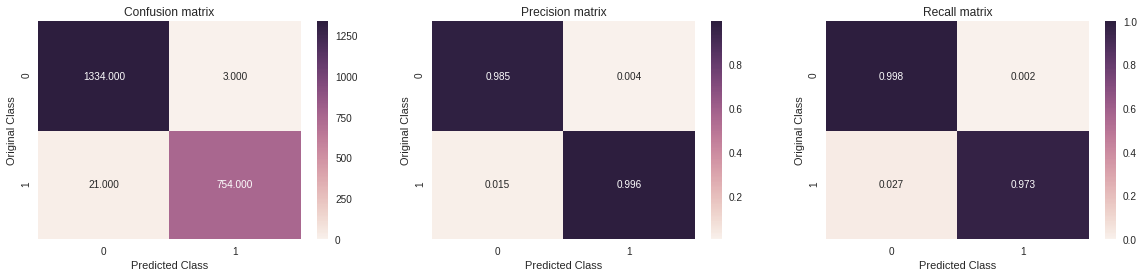

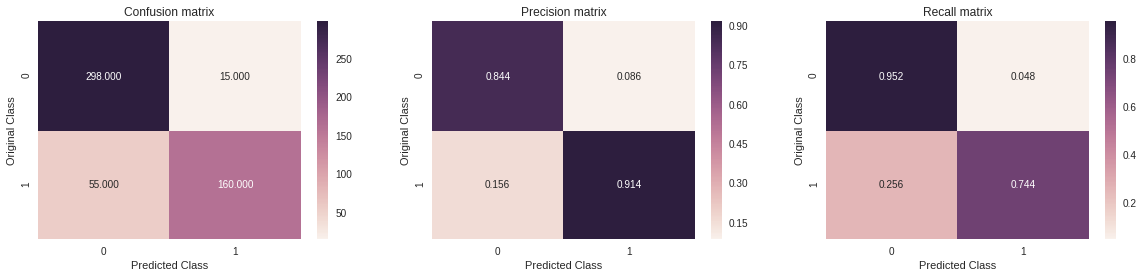

In [21]:
print("Values of best parameters are alpha : 10 and penalty : l2")
print("Training on best parameters...")

clf = SGDClassifier(alpha = 10, penalty = 'l2', loss = 'log')
clf.fit(X_tr, Y_tr)

pred_tr = clf.predict(X_tr)
pred_cv = clf.predict(X_cv)

f1_tr_lr = f1_score(Y_tr, pred_tr)
f1_cv_lr = f1_score(Y_cv, pred_cv)

print("For best parameters train f1 score is", f1_tr_lr, "and cv f1 score is", f1_cv_lr)
plot_confusion_matrix(Y_tr, pred_tr)
plot_confusion_matrix(Y_cv, pred_cv)

## Predictions on test data

Here we, 
1. Take each test image create its 10 patches
2. Extract features of these 10 patches using VGG19 model
3. Classify the patches into 1/0 using the logistic regression we trained above.

In [22]:
clf = SGDClassifier(alpha = 10, penalty = 'l2', loss = 'log')
clf.fit(X_tr, Y_tr)

patch_size = 224                            #patch_size for vgg19 model
no_of_patches = 10                          #hyperparameter that can be tuned
Y_test = []                                 #stores ture labels
pred_test = []                              #stores probabiltes of predicted lables

#for positive training samples
print('Testing on positives images...')
for file_name in pos_test_samples:                                   #for each image
    pred_patch = []                                                  #list to store probabilites value for each patch
    img_path = pos_test_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)       
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_vgg19(patch)
        pred = clf.predict_proba([patch_feature])                    #predict probabilites for each patch
        pred_patch.append(pred[0])                                   #append probabilites, here pred is a list containing a list of probabilites of 2 class 
        
    pred_test.append(np.mean(pred_patch, axis = 0))                  #append mean of patch probabilites
    Y_test.append(1)                                                 #appending 1 for positive samples

    
#for negative training samples
print('Testing on negative images...')
for file_name in neg_test_samples:                                   #for each image
    pred_patch = []                                                  #list to store probabilites value for each patch
    img_path = neg_test_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_vgg19(patch)
        pred = clf.predict_proba([patch_feature])                    #predict probabilites for each patch
        pred_patch.append(pred[0])                                   #append probabilites, here pred is a list containing a list of probabilites of 2 class 
        
    pred_test.append(np.mean(pred_patch, axis = 0))                  #append mean of patch probabilites
    Y_test.append(0)                                                 #appending 0 for negative samples

Testing on positives images...
Testing on negative images...


In [23]:
#Convert probabilites into classes
pred_test = np.argmax(pred_test, axis = 1)
print('Predicted Classes for each test image are :', pred_test)
print('Ture Classes for each test image are :', Y_test)

Predicted Classes for each test image are : [1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ture Classes for each test image are : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


F1 score for test data is 0.8627450980392156


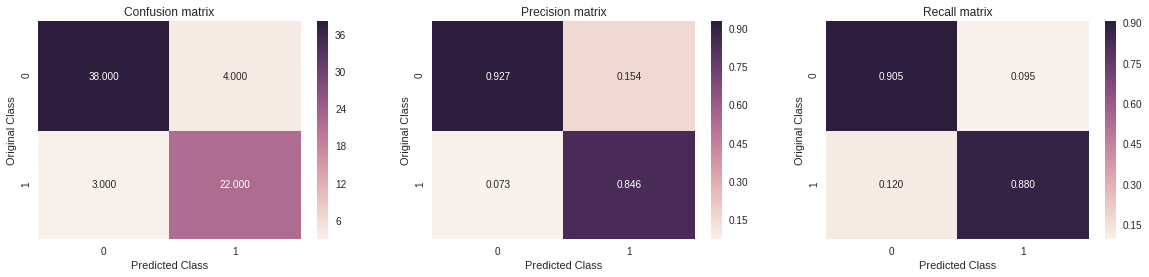

In [24]:
f1_test_vgg19 = f1_score(Y_test, pred_test)

print("F1 score for test data is", f1_test_vgg19)
plot_confusion_matrix(Y_test, pred_test)

# RestNet

In [0]:
resnet50model = resnet50.ResNet50(include_top = False, weights = 'imagenet')                #not importing the top layer

## Creating train dataset

Here we, 
1. Create 10 patches of from each image 
2. Extract features of these patches using ResNet50 model. 
3. Train a logistic regression on these extracted features.

In [0]:
#function to extract features using resnet50 model
def get_patch_feature_resnet50(patch):
    patch_data = np.expand_dims(patch, axis = 0)             #changing the shape of image to 4d, the extra dimension is for batch
    patch_data = resnet50.preprocess_input(patch_data)                #shape = (1, 224, 224, 3)

    patch_feature = resnet50model.predict(patch_data)        #output shape for resnet50 = (1, 7 , 7, 2048)
    patch_feature = patch_feature.reshape(100352)            
    return patch_feature

In [27]:
patch_size = 224                            #patch_size for resnet50 model
no_of_patches = 10                          #hyperparameter that can be tuned
X_train = []
Y_train = []

#for positive training samples
print('Creating patch_features for postive training samples...')
for file_name in pos_train_samples:                                  #for each image
    img_path = pos_train_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_resnet50(patch)
        X_train.append(patch_feature)                                #append patch feature
        Y_train.append(1)                                            #append 1 for positive samples


#for negative training samples
print('Creating patches for negative training samples...')
for file_name in neg_train_samples:                                  #for each image
    img_path = neg_train_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_resnet50(patch)
        X_train.append(patch_feature)                                #append patch feature
        Y_train.append(0)                                            #append 0 for positive samples
        
print('Total number of train data points', len(X_train))

Creating patch_features for postive training samples...
Creating patches for negative training samples...
Total number of train data points 2640


## Splitting the dataset

In [28]:
#our train data is arranged as all positive samples, then all negative samples.
#Shuffling train data

X_train, Y_train = shuffle(X_train, Y_train)
X_train = csr_matrix(X_train)

X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)
print("Shape of tr data, cv data and test data is :", X_tr.shape, X_cv.shape)

Shape of tr data, cv data and test data is : (2112, 100352) (528, 100352)


## Logistic Regression Model

### Parameter Tuning

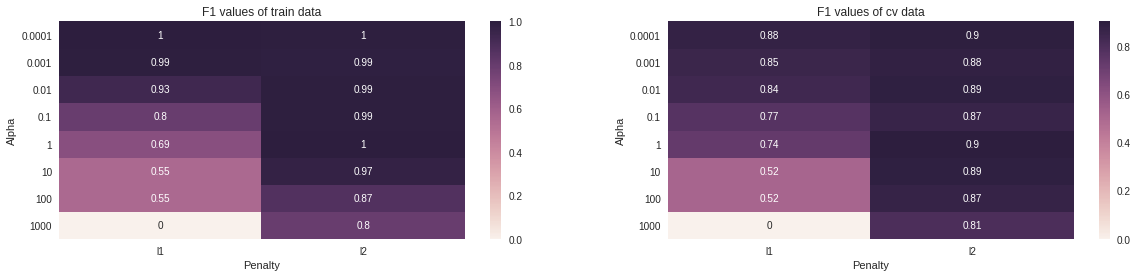

In [29]:
alpha = [10**i for i in range(-4, 4)]
penalty = ['l1', 'l2']
f1_tr_array = []
f1_cv_array = []
for i in alpha:
    for j in penalty:
        clf = SGDClassifier(alpha = i, penalty = j, loss = 'log')
        clf.fit(X_tr, Y_tr)
        pred_tr = clf.predict(X_tr)
        pred_cv = clf.predict(X_cv)

        f1_tr_array.append(f1_score(Y_tr, pred_tr))
        f1_cv_array.append(f1_score(Y_cv, pred_cv))

        
#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
f1_tr_array = np.array(f1_tr_array)
f1_tr_array = f1_tr_array.reshape(len(alpha),len(penalty))
sns.heatmap(f1_tr_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('F1 values of train data')

plt.subplot(1, 2, 2)
f1_cv_array = np.array(f1_cv_array)
f1_cv_array = f1_cv_array.reshape(len(alpha),len(penalty))
sns.heatmap(f1_cv_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('F1 values of cv data')
plt.show()

### Model with best parameter

Values of best parameters are alpha : 10 and penalty : l2
Training on best parameters...
For best parameters train f1 score is 0.9817724701445631 and cv f1 score is 0.8977272727272727


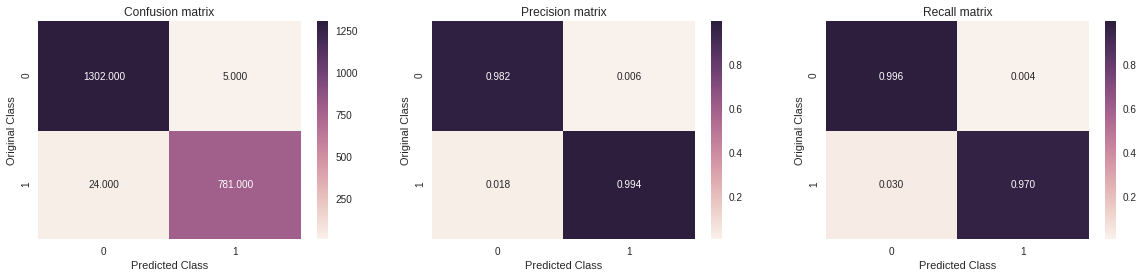

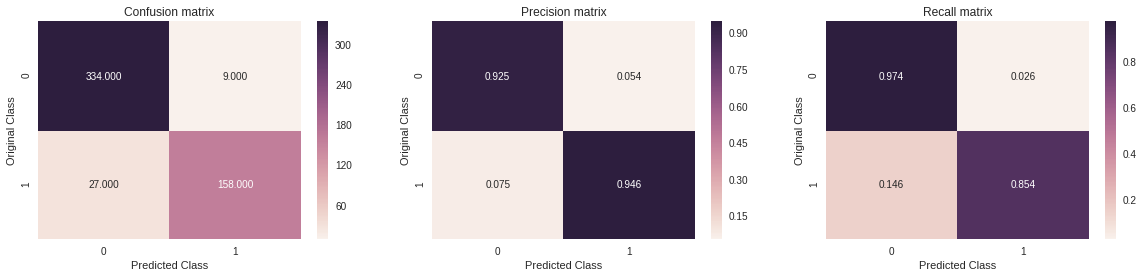

In [30]:
print("Values of best parameters are alpha : 10 and penalty : l2")
print("Training on best parameters...")

clf = SGDClassifier(alpha = 10, penalty = 'l2', loss = 'log')
clf.fit(X_tr, Y_tr)

pred_tr = clf.predict(X_tr)
pred_cv = clf.predict(X_cv)

f1_tr_lr = f1_score(Y_tr, pred_tr)
f1_cv_lr = f1_score(Y_cv, pred_cv)

print("For best parameters train f1 score is", f1_tr_lr, "and cv f1 score is", f1_cv_lr)
plot_confusion_matrix(Y_tr, pred_tr)
plot_confusion_matrix(Y_cv, pred_cv)

## Predictions on test data

Here we, 
1. Take each test image create its 10 patches
2. Extract features of these 10 patches using ResNet50 model
3. Classify the patches into 1/0 using the logistic regression we trained above.

In [31]:
clf = SGDClassifier(alpha = 10, penalty = 'l2', loss = 'log')
clf.fit(X_tr, Y_tr)

patch_size = 224                            #patch_size for resnet50 model
no_of_patches = 10                          #hyperparameter that can be tuned
Y_test = []                                 #stores ture labels
pred_test = []                              #stores probabiltes of predicted lables

#for positive training samples
print('Testing on positives images...')
for file_name in pos_test_samples:                                   #for each image
    pred_patch = []                                                  #list to store probabilites value for each patch
    img_path = pos_test_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)       
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_resnet50(patch)
        pred = clf.predict_proba([patch_feature])                    #predict probabilites for each patch
        pred_patch.append(pred[0])                                   #append probabilites, here pred is a list containing a list of probabilites of 2 class 
        
    pred_test.append(np.mean(pred_patch, axis = 0))                  #append mean of patch probabilites
    Y_test.append(1)                                                 #appending 1 for positive samples

    
#for negative training samples
print('Testing on negative images...')
for file_name in neg_test_samples:                                   #for each image
    pred_patch = []                                                  #list to store probabilites value for each patch
    img_path = neg_test_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_resnet50(patch)
        pred = clf.predict_proba([patch_feature])                    #predict probabilites for each patch
        pred_patch.append(pred[0])                                   #append probabilites, here pred is a list containing a list of probabilites of 2 class 
        
    pred_test.append(np.mean(pred_patch, axis = 0))                  #append mean of patch probabilites
    Y_test.append(0)                                                 #appending 0 for negative samples

Testing on positives images...
Testing on negative images...


In [32]:
#Convert probabilites into classes
pred_test = np.argmax(pred_test, axis = 1)
print('Predicted Classes for each test image are :', pred_test)
print('Ture Classes for each test image are :', Y_test)

Predicted Classes for each test image are : [1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ture Classes for each test image are : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


F1 score for test data is 0.8627450980392156


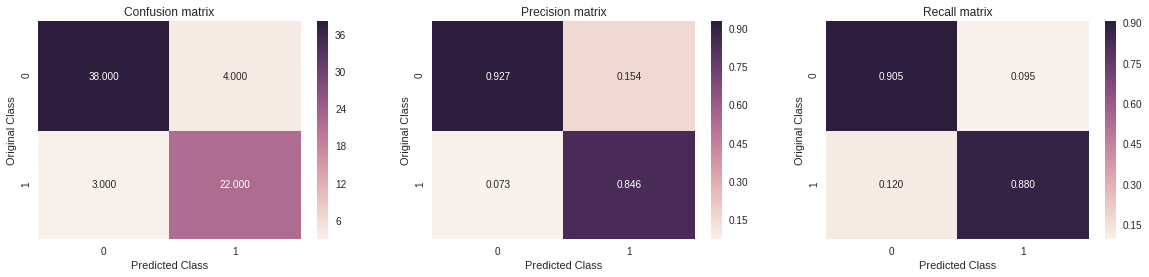

In [33]:
f1_test_resnet50 = f1_score(Y_test, pred_test)

print("F1 score for test data is", f1_test_resnet50)
plot_confusion_matrix(Y_test, pred_test)

# InceptionNet

In [0]:
inceptionv3model = inception_v3.InceptionV3(include_top = False, weights = 'imagenet')                #not importing the top layer

## Creating train dataset

Here we, 
1. Create 10 patches of from each image 
2. Extract features of these patches using InceptionV3 model. 
3. Train a logistic regression on these extracted features.

In [0]:
#function to extract features using inceptionv3 model
def get_patch_feature_inceptionv3(patch):
    patch_data = np.expand_dims(patch, axis = 0)             #changing the shape of image to 4d, the extra dimension is for batch
    patch_data = inception_v3.preprocess_input(patch_data)                #shape = (1, 299, 299, 3)

    patch_feature = inceptionv3model.predict(patch_data)        #output shape for resnet50 = (1, 8 , 8, 2048)
    patch_feature = patch_feature.reshape(131072)            
    return patch_feature

In [36]:
patch_size = 299                            #patch_size for inveption_v3 model
no_of_patches = 10                          #hyperparameter that can be tuned
X_train = []
Y_train = []

#for positive training samples
print('Creating patch_features for postive training samples...')
for file_name in pos_train_samples:                                  #for each image
    img_path = pos_train_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_inceptionv3(patch)
        X_train.append(patch_feature)                                #append patch feature
        Y_train.append(1)                                            #append 1 for positive samples


#for negative training samples
print('Creating patches for negative training samples...')
for file_name in neg_train_samples:                                  #for each image
    img_path = neg_train_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_inceptionv3(patch)
        X_train.append(patch_feature)                                #append patch feature
        Y_train.append(0)                                            #append 0 for positive samples
        
print('Total number of train data points', len(X_train))

Creating patch_features for postive training samples...
Creating patches for negative training samples...
Total number of train data points 2640


## Splitting the dataset

In [37]:
#our train data is arranged as all positive samples, then all negative samples.
#Shuffling train data

X_train, Y_train = shuffle(X_train, Y_train)
X_train = csr_matrix(X_train)

X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)
print("Shape of tr data, cv data and test data is :", X_tr.shape, X_cv.shape)

Shape of tr data, cv data and test data is : (2112, 131072) (528, 131072)


## Logistic Regression Model

### Parameter Tuning

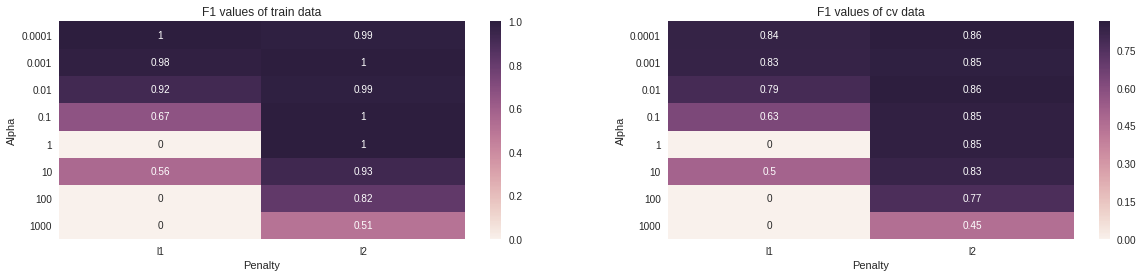

In [38]:
alpha = [10**i for i in range(-4, 4)]
penalty = ['l1', 'l2']
f1_tr_array = []
f1_cv_array = []
for i in alpha:
    for j in penalty:
        clf = SGDClassifier(alpha = i, penalty = j, loss = 'log')
        clf.fit(X_tr, Y_tr)
        pred_tr = clf.predict(X_tr)
        pred_cv = clf.predict(X_cv)

        f1_tr_array.append(f1_score(Y_tr, pred_tr))
        f1_cv_array.append(f1_score(Y_cv, pred_cv))

        
#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
f1_tr_array = np.array(f1_tr_array)
f1_tr_array = f1_tr_array.reshape(len(alpha),len(penalty))
sns.heatmap(f1_tr_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('F1 values of train data')

plt.subplot(1, 2, 2)
f1_cv_array = np.array(f1_cv_array)
f1_cv_array = f1_cv_array.reshape(len(alpha),len(penalty))
sns.heatmap(f1_cv_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('F1 values of cv data')
plt.show()

### Model with best parameter

Values of best parameters are alpha : 10 and penalty : l2
Training on best parameters...
For best parameters train f1 score is 0.9365791159513133 and cv f1 score is 0.8217522658610271


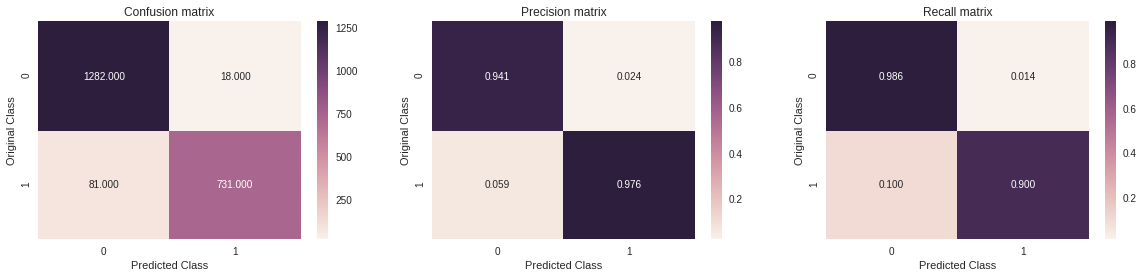

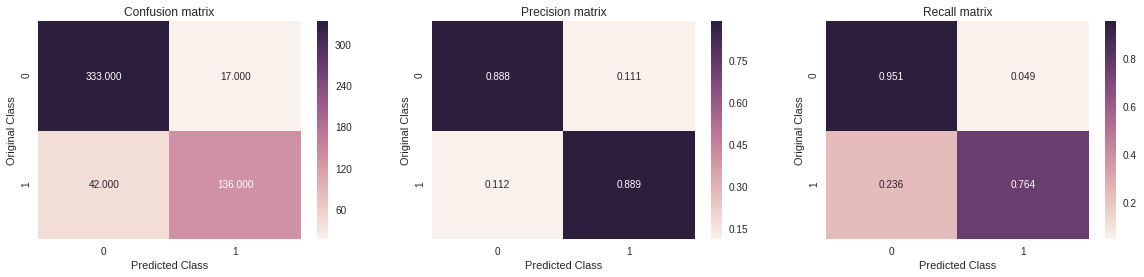

In [39]:
print("Values of best parameters are alpha : 10 and penalty : l2")
print("Training on best parameters...")

clf = SGDClassifier(alpha = 10, penalty = 'l2', loss = 'log')
clf.fit(X_tr, Y_tr)

pred_tr = clf.predict(X_tr)
pred_cv = clf.predict(X_cv)

f1_tr_lr = f1_score(Y_tr, pred_tr)
f1_cv_lr = f1_score(Y_cv, pred_cv)

print("For best parameters train f1 score is", f1_tr_lr, "and cv f1 score is", f1_cv_lr)
plot_confusion_matrix(Y_tr, pred_tr)
plot_confusion_matrix(Y_cv, pred_cv)

## Predictions on test data

Here we, 
1. Take each test image create its 10 patches
2. Extract features of these 10 patches using InceptionV3 model
3. Classify the patches into 1/0 using the logistic regression we trained above.

In [40]:
clf = SGDClassifier(alpha = 10, penalty = 'l2', loss = 'log')
clf.fit(X_tr, Y_tr)

patch_size = 299                            #patch_size for inceptionv3 model
no_of_patches = 10                          #hyperparameter that can be tuned
Y_test = []                                 #stores ture labels
pred_test = []                              #stores probabiltes of predicted lables

#for positive training samples
print('Testing on positives images...')
for file_name in pos_test_samples:                                   #for each image
    pred_patch = []                                                  #list to store probabilites value for each patch
    img_path = pos_test_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)       
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_inceptionv3(patch)
        pred = clf.predict_proba([patch_feature])                    #predict probabilites for each patch
        pred_patch.append(pred[0])                                   #append probabilites, here pred is a list containing a list of probabilites of 2 class 
        
    pred_test.append(np.mean(pred_patch, axis = 0))                  #append mean of patch probabilites
    Y_test.append(1)                                                 #appending 1 for positive samples

    
#for negative training samples
print('Testing on negative images...')
for file_name in neg_test_samples:                                   #for each image
    pred_patch = []                                                  #list to store probabilites value for each patch
    img_path = neg_test_dir + '/' + file_name
    patches = get_patches(img_path, patch_size, no_of_patches)
    
    for patch in patches:                                            #for each patch of each image
        patch_feature = get_patch_feature_inceptionv3(patch)
        pred = clf.predict_proba([patch_feature])                    #predict probabilites for each patch
        pred_patch.append(pred[0])                                   #append probabilites, here pred is a list containing a list of probabilites of 2 class 
        
    pred_test.append(np.mean(pred_patch, axis = 0))                  #append mean of patch probabilites
    Y_test.append(0)                                                 #appending 0 for negative samples

Testing on positives images...
Testing on negative images...


In [41]:
#Convert probabilites into classes
pred_test = np.argmax(pred_test, axis = 1)
print('Predicted Classes for each test image are :', pred_test)
print('Ture Classes for each test image are :', Y_test)

Predicted Classes for each test image are : [1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ture Classes for each test image are : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


F1 score for test data is 0.9019607843137256


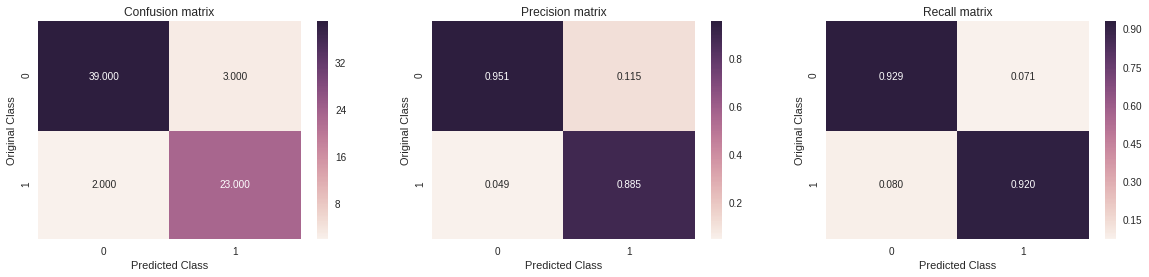

In [42]:
f1_test_inceptionv3 = f1_score(Y_test, pred_test)

print("F1 score for test data is", f1_test_inceptionv3)
plot_confusion_matrix(Y_test, pred_test)

# Model Comparison

In [43]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['CNN Model','F1 Score']
t.add_row(['VGG16', f1_test_vgg16])
t.add_row(['VGG19',f1_test_vgg19])
t.add_row(['ResNet50',f1_test_resnet50])
t.add_row(['InceptionV3',f1_test_inceptionv3])
print(t)

+-------------+--------------------+
|  CNN Model  |      F1 Score      |
+-------------+--------------------+
|    VGG16    | 0.8846153846153846 |
|    VGG19    | 0.8627450980392156 |
|   ResNet50  | 0.8627450980392156 |
| InceptionV3 | 0.9019607843137256 |
+-------------+--------------------+
